In [1]:
!pip install transformers
!pip install kagglehub
!pip install kaggle
!pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import kagglehub
import os
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv

In [3]:
dir = kagglehub.dataset_download("neisse/scrapped-lyrics-from-6-genres")
list_dir = os.listdir(dir)
files = []
for file in list_dir:
  files.append(os.path.join(dir, file))

In [4]:
files

['/usr4/ds549/yuanlj/.cache/kagglehub/datasets/neisse/scrapped-lyrics-from-6-genres/versions/3/artists-data.csv',
 '/usr4/ds549/yuanlj/.cache/kagglehub/datasets/neisse/scrapped-lyrics-from-6-genres/versions/3/lyrics-data.csv']

# GPT2 with Fine Tuning

### Prepare data

In [5]:
lyrics = pd.read_csv(files[1])

In [6]:
lyrics.describe()

,ALink,SName,SLink,Lyric,language
count,379930,379928,379930,379854,365296
unique,4238,267258,379892,371181,52
top,/anjos-anonimos/,Intro,/joan-baez/aint-gonna-let-nobody-turn-me-aroun...,Instrumental,en
freq,1029,116,2,2087,191814


In [7]:
lyrics = lyrics[lyrics['language']=='en']
lyrics = lyrics.reset_index(drop=True)

In [8]:
len(lyrics)

191814

In [9]:
#Drop the songs with lyrics too long (after more than 1024 tokens, does not work)
lyircs = lyrics[lyrics['Lyric'].apply(lambda x: len(x.split(' '))<350)]

In [10]:
len(lyrics)

191814

In [11]:
#Create a very small test set to compare generated text with the reality
lyrics_test = lyrics.sample(n = 500)
lyrics = lyrics.loc[~lyrics.index.isin(lyrics_test.index)]

#Reset the indexes
lyrics_test = lyrics_test.reset_index()
lyrics = lyircs.reset_index()

In [12]:
#For the test set only, keep last 20 words in a new column, then remove them from original column
# test_set['True_end_lyrics'] = test_set['Lyric'].str.split().str[-20:].apply(' '.join)
# test_set['Lyric'] = test_set['Lyric'].str.split().str[:-20].apply(' '.join)

In [13]:
# test_set.head()

### Prepare the dataset

In [14]:
class SongLyrics(Dataset):

    def __init__(self, control_code, truncate=False, gpt2_type="gpt2", max_length=1024):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.lyrics = []

        for row in lyrics['Lyric']:
          self.lyrics.append(torch.tensor(
                self.tokenizer.encode(f"<|{control_code}|>{row[:max_length]}<|endoftext|>")
            ))

        if truncate:
            self.lyrics = self.lyrics[:20000]

        self.lyrics_count = len(self.lyrics)

    def __len__(self):
        return self.lyrics_count

    def __getitem__(self, item):
        return self.lyrics[item]

In [15]:
dataset = SongLyrics(lyrics['Lyric'], truncate=True, gpt2_type="gpt2")

Token indices sequence length is longer than the specified maximum sequence length for this model (1057 > 1024). Running this sequence through the model will result in indexing errors


### Prepare training

In [16]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [17]:
#Accumulated batch size (since GPT2 is so big)
def pack_tensor(new_tensor, packed_tensor, max_seq_len):
    if packed_tensor is None:
        return new_tensor, True, None
    if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
        return packed_tensor, False, new_tensor
    else:
        packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
        return packed_tensor, True, None

In [18]:
def train(dataset, model, tokenizer, batch_size=16, epochs=10, lr=2e-5, max_seq_len=400, warmup_steps=200,
    gpt2_type="gpt2", output_dir=".", output_prefix="wreckgar", test_mode=False, save_model_on_epoch=True,
):

    acc_steps = 100
    device=torch.device("cuda")
    model = model.cuda()
    model.train()

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1)

    train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    batch_amount = len(train_dataloader)
    Loss = []
    Ave_Loss = []
    accumulating_batch_count = 0
    input_tensor = None

    for epoch in range(epochs):
        total_loss = 0

        print(f"Staring training epoch {epoch+1}")

        for idx, entry in tqdm(enumerate(train_dataloader)):
            (input_tensor, carry_on, remainder) = pack_tensor(entry, input_tensor, 768)

            if carry_on and idx != len(train_dataloader) - 1:
                continue

            input_tensor = input_tensor.to(device)
            outputs = model(input_tensor, labels=input_tensor)
            loss = outputs[0]
            loss.backward()

            if (accumulating_batch_count % batch_size) == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            accumulating_batch_count += 1
            input_tensor = None
            if idx%1000 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{idx+1}/{batch_amount}], Loss: {loss.item():.4f}")
                Loss.append(loss.item())
            total_loss += loss.item()

        if save_model_on_epoch and epoch>6:
            torch.save(model.state_dict(), os.path.join(output_dir, f"{output_prefix}-{epoch}.pt"),)
        print(f"Epoch [{epoch+1}/{epochs}] completed with Loss: {total_loss/batch_amount}")
        Ave_Loss.append(total_loss/batch_amount)

    return model, Loss, Ave_Loss

### Actual Training

In [19]:
#Train the model on the specific data we have
model, loss, ave_loss = train(dataset, model, tokenizer)

/usr4/ds549/yuanlj/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Staring training epoch 1


5011it [01:08, 70.90it/s]

Epoch [1/10], Step [5001/20000], Loss: 1.8074


6011it [01:22, 73.98it/s]

Epoch [1/10], Step [6001/20000], Loss: 1.0380


8015it [01:50, 74.64it/s]

Epoch [1/10], Step [8001/20000], Loss: 1.3995


9015it [02:03, 72.96it/s]

Epoch [1/10], Step [9001/20000], Loss: 1.3884


10013it [02:17, 74.45it/s]

Epoch [1/10], Step [10001/20000], Loss: 0.9945


11011it [02:31, 72.98it/s]

Epoch [1/10], Step [11001/20000], Loss: 1.8280


12007it [02:45, 71.69it/s]

Epoch [1/10], Step [12001/20000], Loss: 0.9047


13009it [02:59, 71.34it/s]

Epoch [1/10], Step [13001/20000], Loss: 1.3260


14009it [03:12, 70.31it/s]

Epoch [1/10], Step [14001/20000], Loss: 1.2188


15007it [03:26, 74.52it/s]

Epoch [1/10], Step [15001/20000], Loss: 1.0173


16009it [03:40, 71.90it/s]

Epoch [1/10], Step [16001/20000], Loss: 1.1292


17015it [03:54, 71.16it/s]

Epoch [1/10], Step [17001/20000], Loss: 1.7560


18009it [04:08, 73.65it/s]

Epoch [1/10], Step [18001/20000], Loss: 1.7469


19011it [04:22, 72.41it/s]

Epoch [1/10], Step [19001/20000], Loss: 2.2891


20000it [04:35, 72.48it/s]


Epoch [1/10] completed with Loss: 0.7572664882287383
Staring training epoch 2


2013it [00:27, 72.65it/s]

Epoch [2/10], Step [2001/20000], Loss: 1.5784


3009it [00:41, 76.27it/s]

Epoch [2/10], Step [3001/20000], Loss: 1.0098


4011it [00:55, 75.25it/s]

Epoch [2/10], Step [4001/20000], Loss: 0.9897


5009it [01:09, 72.32it/s]

Epoch [2/10], Step [5001/20000], Loss: 1.6766


6011it [01:23, 70.40it/s]

Epoch [2/10], Step [6001/20000], Loss: 1.1798


7009it [01:37, 73.11it/s]

Epoch [2/10], Step [7001/20000], Loss: 1.7047


8015it [01:50, 75.14it/s]

Epoch [2/10], Step [8001/20000], Loss: 1.0443


9011it [02:04, 72.37it/s]

Epoch [2/10], Step [9001/20000], Loss: 1.0961


10015it [02:18, 72.91it/s]

Epoch [2/10], Step [10001/20000], Loss: 1.7096


11009it [02:32, 74.91it/s]

Epoch [2/10], Step [11001/20000], Loss: 0.8926


12009it [02:46, 72.33it/s]

Epoch [2/10], Step [12001/20000], Loss: 1.2625


13015it [02:59, 74.43it/s]

Epoch [2/10], Step [13001/20000], Loss: 1.1740


16007it [03:41, 72.05it/s]

Epoch [2/10], Step [16001/20000], Loss: 1.2865


17013it [03:55, 72.12it/s]

Epoch [2/10], Step [17001/20000], Loss: 1.4046


18015it [04:09, 72.13it/s]

Epoch [2/10], Step [18001/20000], Loss: 1.2594


20000it [04:36, 72.32it/s]


Epoch [2/10] completed with Loss: 0.6418038769483566
Staring training epoch 3


5013it [01:09, 73.36it/s]

Epoch [3/10], Step [5001/20000], Loss: 0.8113


6009it [01:23, 71.56it/s]

Epoch [3/10], Step [6001/20000], Loss: 1.3867


8011it [01:50, 74.46it/s]

Epoch [3/10], Step [8001/20000], Loss: 1.5552


9009it [02:04, 71.69it/s]

Epoch [3/10], Step [9001/20000], Loss: 1.4403


10015it [02:18, 70.37it/s]

Epoch [3/10], Step [10001/20000], Loss: 1.2094


11011it [02:32, 69.74it/s]

Epoch [3/10], Step [11001/20000], Loss: 1.2268


12013it [02:46, 72.21it/s]

Epoch [3/10], Step [12001/20000], Loss: 0.9432


13009it [02:59, 69.84it/s]

Epoch [3/10], Step [13001/20000], Loss: 1.2841


14011it [03:13, 74.31it/s]

Epoch [3/10], Step [14001/20000], Loss: 0.8537


15013it [03:27, 73.07it/s]

Epoch [3/10], Step [15001/20000], Loss: 0.9774


16015it [03:41, 74.57it/s]

Epoch [3/10], Step [16001/20000], Loss: 1.0224


18013it [04:08, 72.59it/s]

Epoch [3/10], Step [18001/20000], Loss: 1.4945


19011it [04:22, 74.94it/s]

Epoch [3/10], Step [19001/20000], Loss: 1.0421


20000it [04:35, 72.48it/s]


Epoch [3/10] completed with Loss: 0.6443829024367035
Staring training epoch 4


4013it [00:55, 77.17it/s]

Epoch [4/10], Step [4001/20000], Loss: 1.0786


5009it [01:09, 70.85it/s]

Epoch [4/10], Step [5001/20000], Loss: 1.5928


7013it [01:36, 73.73it/s]

Epoch [4/10], Step [7001/20000], Loss: 1.6603


8015it [01:50, 74.99it/s]

Epoch [4/10], Step [8001/20000], Loss: 0.6946


9012it [02:04, 71.54it/s]

Epoch [4/10], Step [9001/20000], Loss: 1.5012


10011it [02:18, 69.79it/s]

Epoch [4/10], Step [10001/20000], Loss: 1.0260


11009it [02:32, 71.26it/s]

Epoch [4/10], Step [11001/20000], Loss: 1.5919


15011it [03:27, 73.74it/s]

Epoch [4/10], Step [15001/20000], Loss: 1.9698


16015it [03:41, 74.11it/s]

Epoch [4/10], Step [16001/20000], Loss: 1.0314


17011it [03:55, 71.67it/s]

Epoch [4/10], Step [17001/20000], Loss: 1.4229


18009it [04:08, 70.04it/s]

Epoch [4/10], Step [18001/20000], Loss: 1.5008


19009it [04:22, 71.11it/s]

Epoch [4/10], Step [19001/20000], Loss: 1.4007


20000it [04:36, 72.35it/s]


Epoch [4/10] completed with Loss: 0.6426487402513623
Staring training epoch 5


3015it [00:41, 73.93it/s]

Epoch [5/10], Step [3001/20000], Loss: 1.0015


4009it [00:55, 71.85it/s]

Epoch [5/10], Step [4001/20000], Loss: 1.1138


7013it [01:36, 73.77it/s]

Epoch [5/10], Step [7001/20000], Loss: 0.9402


13011it [02:59, 72.10it/s]

Epoch [5/10], Step [13001/20000], Loss: 1.0446


14007it [03:13, 70.46it/s]

Epoch [5/10], Step [14001/20000], Loss: 1.7492


20000it [04:35, 72.54it/s]


Epoch [5/10] completed with Loss: 0.6415442114025355
Staring training epoch 6


6013it [01:23, 71.40it/s]

Epoch [6/10], Step [6001/20000], Loss: 1.3030


7015it [01:36, 71.98it/s]

Epoch [6/10], Step [7001/20000], Loss: 1.1138


8009it [01:50, 72.36it/s]

Epoch [6/10], Step [8001/20000], Loss: 1.5181


9009it [02:04, 72.80it/s]

Epoch [6/10], Step [9001/20000], Loss: 1.3647


13013it [02:59, 72.08it/s]

Epoch [6/10], Step [13001/20000], Loss: 0.8097


20000it [04:35, 72.47it/s]


Epoch [6/10] completed with Loss: 0.6424616861023009
Staring training epoch 7


7015it [01:36, 73.16it/s]

Epoch [7/10], Step [7001/20000], Loss: 0.9208


8011it [01:50, 70.43it/s]

Epoch [7/10], Step [8001/20000], Loss: 0.8131


9011it [02:04, 75.22it/s]

Epoch [7/10], Step [9001/20000], Loss: 1.1190


10013it [02:18, 70.59it/s]

Epoch [7/10], Step [10001/20000], Loss: 1.8191


11015it [02:32, 70.73it/s]

Epoch [7/10], Step [11001/20000], Loss: 1.2654


12013it [02:46, 72.19it/s]

Epoch [7/10], Step [12001/20000], Loss: 1.3568


13009it [02:59, 70.89it/s]

Epoch [7/10], Step [13001/20000], Loss: 1.8995


14015it [03:13, 75.40it/s]

Epoch [7/10], Step [14001/20000], Loss: 1.3997


15011it [03:27, 71.44it/s]

Epoch [7/10], Step [15001/20000], Loss: 1.5351


16013it [03:41, 73.43it/s]

Epoch [7/10], Step [16001/20000], Loss: 1.3906


17009it [03:54, 72.40it/s]

Epoch [7/10], Step [17001/20000], Loss: 0.9957


18009it [04:08, 73.14it/s]

Epoch [7/10], Step [18001/20000], Loss: 1.0083


19015it [04:22, 72.00it/s]

Epoch [7/10], Step [19001/20000], Loss: 1.5107


20000it [04:36, 72.44it/s]


Epoch [7/10] completed with Loss: 0.6416588691450655
Staring training epoch 8


1011it [00:13, 74.79it/s]

Epoch [8/10], Step [1001/20000], Loss: 1.1025


2009it [00:27, 71.61it/s]

Epoch [8/10], Step [2001/20000], Loss: 1.3089


3011it [00:41, 71.80it/s]

Epoch [8/10], Step [3001/20000], Loss: 1.5412


13011it [02:58, 73.58it/s]

Epoch [8/10], Step [13001/20000], Loss: 0.9537


14015it [03:12, 74.65it/s]

Epoch [8/10], Step [14001/20000], Loss: 0.8382


15011it [03:26, 74.49it/s]

Epoch [8/10], Step [15001/20000], Loss: 1.3722


16015it [03:39, 71.99it/s]

Epoch [8/10], Step [16001/20000], Loss: 1.4835


17013it [03:53, 73.65it/s]

Epoch [8/10], Step [17001/20000], Loss: 1.6615


18009it [04:07, 72.96it/s]

Epoch [8/10], Step [18001/20000], Loss: 1.1352


19016it [04:21, 76.82it/s]

Epoch [8/10], Step [19001/20000], Loss: 1.1330


20000it [04:34, 72.82it/s]


Epoch [8/10] completed with Loss: 0.6437070368357003
Staring training epoch 9


3007it [00:41, 70.36it/s]

Epoch [9/10], Step [3001/20000], Loss: 1.6609


4009it [00:55, 71.31it/s]

Epoch [9/10], Step [4001/20000], Loss: 1.3389


7015it [01:36, 72.32it/s]

Epoch [9/10], Step [7001/20000], Loss: 1.2404


8013it [01:50, 75.83it/s]

Epoch [9/10], Step [8001/20000], Loss: 0.6392


11015it [02:31, 73.68it/s]

Epoch [9/10], Step [11001/20000], Loss: 1.2722


12007it [02:45, 73.05it/s]

Epoch [9/10], Step [12001/20000], Loss: 1.6032


13009it [02:59, 69.80it/s]

Epoch [9/10], Step [13001/20000], Loss: 1.8370


14012it [03:13, 71.39it/s]

Epoch [9/10], Step [14001/20000], Loss: 1.0682


15011it [03:26, 73.02it/s]

Epoch [9/10], Step [15001/20000], Loss: 1.2498


16011it [03:40, 71.69it/s]

Epoch [9/10], Step [16001/20000], Loss: 1.0865


20000it [04:35, 72.60it/s]


Epoch [9/10] completed with Loss: 0.6430293638713658
Staring training epoch 10


2013it [00:27, 70.00it/s]

Epoch [10/10], Step [2001/20000], Loss: 1.0644


3015it [00:41, 72.92it/s]

Epoch [10/10], Step [3001/20000], Loss: 1.2386


4015it [00:55, 70.03it/s]

Epoch [10/10], Step [4001/20000], Loss: 1.4520


5011it [01:09, 71.68it/s]

Epoch [10/10], Step [5001/20000], Loss: 1.5884


7011it [01:36, 71.10it/s]

Epoch [10/10], Step [7001/20000], Loss: 1.3315


8011it [01:50, 71.98it/s]

Epoch [10/10], Step [8001/20000], Loss: 0.7152


9015it [02:04, 70.37it/s]

Epoch [10/10], Step [9001/20000], Loss: 1.5279


10009it [02:18, 72.15it/s]

Epoch [10/10], Step [10001/20000], Loss: 1.1833


14013it [03:13, 71.54it/s]

Epoch [10/10], Step [14001/20000], Loss: 1.1120


15011it [03:27, 72.17it/s]

Epoch [10/10], Step [15001/20000], Loss: 1.4418


16009it [03:41, 73.41it/s]

Epoch [10/10], Step [16001/20000], Loss: 0.9180


17012it [03:55, 73.56it/s]

Epoch [10/10], Step [17001/20000], Loss: 1.5418


18013it [04:08, 72.25it/s]

Epoch [10/10], Step [18001/20000], Loss: 1.6482


19011it [04:22, 70.45it/s]

Epoch [10/10], Step [19001/20000], Loss: 2.0818


20000it [04:36, 72.37it/s]


Epoch [10/10] completed with Loss: 0.6462483141332864


In [23]:
ave_loss

[0.7572664882287383,
 0.6418038769483566,
 0.6443829024367035,
 0.6426487402513623,
 0.6415442114025355,
 0.6424616861023009,
 0.6416588691450655,
 0.6437070368357003,
 0.6430293638713658,
 0.6462483141332864]

In [24]:
loss

[1.8074134588241577,
 1.037966251373291,
 1.3995392322540283,
 1.388369083404541,
 0.9944681525230408,
 1.8279857635498047,
 0.9047303795814514,
 1.325980305671692,
 1.2188364267349243,
 1.0173062086105347,
 1.1292206048965454,
 1.7560254335403442,
 1.7468602657318115,
 2.2890963554382324,
 1.5784012079238892,
 1.009793758392334,
 0.9897134304046631,
 1.6766033172607422,
 1.1797816753387451,
 1.7047085762023926,
 1.0443180799484253,
 1.0961260795593262,
 1.7095803022384644,
 0.8925700783729553,
 1.2625304460525513,
 1.1739758253097534,
 1.286540150642395,
 1.4046145677566528,
 1.2593636512756348,
 0.8113195300102234,
 1.3867460489273071,
 1.555240273475647,
 1.44027578830719,
 1.2094459533691406,
 1.226783275604248,
 0.9432076811790466,
 1.2841004133224487,
 0.8537415266036987,
 0.9774059057235718,
 1.0223867893218994,
 1.4944884777069092,
 1.042106032371521,
 1.0786417722702026,
 1.5927791595458984,
 1.660296082496643,
 0.694636881351471,
 1.5012176036834717,
 1.0259863138198853,
 1.5

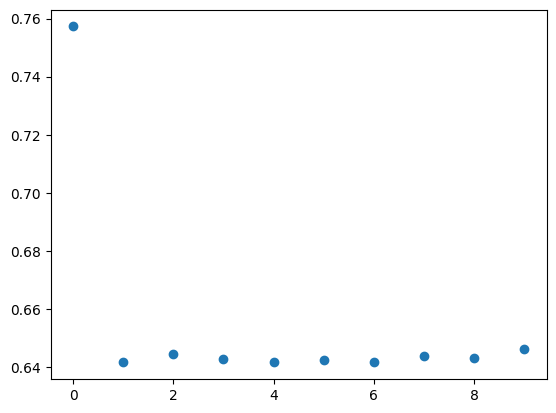

In [28]:
import matplotlib.pyplot as plt
plt.scatter(range(len(ave_loss)),ave_loss)

### Text generation

In [35]:
#Load the model to use it

In [39]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.load_state_dict(torch.load('wreckgar-9.pt', weights_only=True))
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)